## Country flags

### Import packages

In [1]:
import numpy as np

import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from cairosvg import svg2png

import matplotlib.pyplot as plt
import seaborn as sns
import colorsys

### Scrape image sources from wikipedia article

In [2]:
URL = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

sources = soup.find_all('img', class_='thumbborder')
sources[2]

<img alt="" class="thumbborder" data-file-height="650" data-file-width="1235" decoding="async" height="12" src="//upload.wikimedia.org/wikipedia/en/thumb/a/a4/Flag_of_the_United_States.svg/23px-Flag_of_the_United_States.svg.png" srcset="//upload.wikimedia.org/wikipedia/en/thumb/a/a4/Flag_of_the_United_States.svg/35px-Flag_of_the_United_States.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/a/a4/Flag_of_the_United_States.svg/46px-Flag_of_the_United_States.svg.png 2x" width="23"/>

In [3]:
sources = soup.find_all('tbody')
entries = sources[0].find_all('tr')[2:]
entry = entries[3]

### Extract the country information from the scraped source data

In [4]:
def get_flag_url(source):
    src = str(source)
    pos_start = src.find("upload.wikimedia.org/")
    pos_end = src.find(".svg.png")
    url = 'https://' + src[pos_start:pos_end+len(".svg.png")]
    return url

In [5]:
def get_country_name(entry):
    useables = entry.find_all('td')[0:3]
    country_info = useables[0].find_all('a')
    src = str(country_info)
    pos_start = src.find('">') + 2
    pos_end = src.find('</a>')
    return src[pos_start:pos_end]

In [6]:
def get_continent(entry):
    useables = entry.find_all('td')[0:3]
    src = str(useables)
    continents = ['Asia', 'Europe', 'Americas', 'Africa', 'Oceania']
    for continent in continents:
        if continent in src:
            return continent

In [7]:
def get_population(entry):
    useables = entry.find_all('td')[0:3]
    population_info = useables[2]
    src = str(population_info)
    pos_start = src.find('">') + 2
    pos_end = src.find('</td>')
    return src[pos_start:pos_end]

Extracting important information from the data

In [8]:
names = [get_country_name(entry) for entry in entries]
continents = [get_continent(entry) for entry in entries]
populations = [get_population(entry) for entry in entries]
URLs = [get_flag_url(entry) for entry in entries]

In [9]:
def modify_URL(URL):
    URL = URL.replace('/thumb', '')
    return URL[:URL.rfind('/')]

svg_URLs = [modify_URL(URL) for URL in URLs]

In [21]:
def get_flag_filename(URL):
    return URL[URL.rfind('/')+1:-4]

flag_filenames = [get_flag_filename(URL) for URL in svg_URLs]

import pickle
with open('filenames.pkl', 'wb') as f:
    pickle.dump(flag_filenames, f)

Quickly verifying correctness of scraped data

In [12]:
print(len(names), len(continents), len(populations), len(URLs))
for i in 24*np.arange(10):
    print(names[i], continents[i], populations[i])

241 241 241 241
China Asia 1,412,600,000
Italy Europe 58,983,122
Nepal Asia 29,192,480
Zimbabwe Africa 15,790,716
Belarus Europe 9,349,645
Palestine Asia 5,227,193
Botswana Africa 2,410,338
Montenegro Europe 621,306
Grenada Americas 113,000
Liechtenstein Europe 39,151


### Read the images from the URLs and convert them to RGB scale

In [13]:
def get_RGB_colors_from_url(URL):
    response = requests.get(URL)
    img = Image.open(BytesIO(response.content))
    RGB_image = img.convert('RGB')
    width, height = RGB_image.size
    RGB_color = np.empty((width, height, 3))
    for i in range(width):
        for j in range(height):
            RGB_color[i, j, :] = RGB_image.getpixel((i, j))
    return RGB_color

In [14]:
RGB_colors = [get_RGB_colors_from_url(URL) for URL in URLs]

C:\Users\Fabio\Anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [141]:
def get_svg_image(url):
    svg = requests.get(url).text
    png = svg2png(bytestring=svg)
    img = Image.open(BytesIO(png)).convert('RGBA')
    return img

def RGB_to_array(img):
    width, height = img.size
    RGBA_array = np.empty((width, height, 4), dtype=np.uint8)
    for i in range(width):
        for j in range(height):
            RGBA_array[i, j, :] = img.getpixel((i, j))
    return RGBA_array

In [130]:
flags1 = [get_svg_image(svg_URL) for svg_URL in svg_URLs[:100]]
RGBA_flags1 = [RGB_to_array(flag) for flag in flags1]

In [143]:
flags2 = [get_svg_image(svg_URL) for svg_URL in svg_URLs[100:150]]
RGBA_flags2 = [RGB_to_array(flag) for flag in flags2]

https://upload.wikimedia.org/wikipedia/commons/1/17/Flag_of_Sierra_Leone.svg
https://upload.wikimedia.org/wikipedia/commons/6/68/Flag_of_Togo.svg
https://upload.wikimedia.org/wikipedia/commons/5/5b/Flag_of_Hong_Kong.svg
https://upload.wikimedia.org/wikipedia/commons/2/27/Flag_of_Paraguay.svg
https://upload.wikimedia.org/wikipedia/commons/5/56/Flag_of_Laos.svg
https://upload.wikimedia.org/wikipedia/commons/0/05/Flag_of_Libya.svg
https://upload.wikimedia.org/wikipedia/commons/f/ff/Flag_of_Serbia.svg
https://upload.wikimedia.org/wikipedia/commons/3/34/Flag_of_El_Salvador.svg
https://upload.wikimedia.org/wikipedia/commons/5/59/Flag_of_Lebanon.svg
https://upload.wikimedia.org/wikipedia/commons/c/c7/Flag_of_Kyrgyzstan.svg
https://upload.wikimedia.org/wikipedia/commons/1/19/Flag_of_Nicaragua.svg
https://upload.wikimedia.org/wikipedia/commons/9/9a/Flag_of_Bulgaria.svg
https://upload.wikimedia.org/wikipedia/commons/1/1b/Flag_of_Turkmenistan.svg
https://upload.wikimedia.org/wikipedia/commons/9/9

In [145]:
flags3 = [get_svg_image(svg_URL) for svg_URL in svg_URLs[150:175]]
RGBA_flags3 = [RGB_to_array(flag) for flag in flags3]

https://upload.wikimedia.org/wikipedia/commons/1/1f/Flag_of_Kosovo.svg
https://upload.wikimedia.org/wikipedia/commons/0/01/Flag_of_Guinea-Bissau.svg
https://upload.wikimedia.org/wikipedia/commons/3/31/Flag_of_Equatorial_Guinea.svg
https://upload.wikimedia.org/wikipedia/commons/2/2c/Flag_of_Bahrain.svg
https://upload.wikimedia.org/wikipedia/commons/6/64/Flag_of_Trinidad_and_Tobago.svg
https://upload.wikimedia.org/wikipedia/commons/8/8f/Flag_of_Estonia.svg
https://upload.wikimedia.org/wikipedia/commons/2/26/Flag_of_East_Timor.svg
https://upload.wikimedia.org/wikipedia/commons/7/77/Flag_of_Mauritius.svg
https://upload.wikimedia.org/wikipedia/commons/f/fb/Flag_of_Eswatini.svg
https://upload.wikimedia.org/wikipedia/commons/3/34/Flag_of_Djibouti.svg
https://upload.wikimedia.org/wikipedia/commons/b/ba/Flag_of_Fiji.svg
https://upload.wikimedia.org/wikipedia/commons/d/d4/Flag_of_Cyprus.svg
https://upload.wikimedia.org/wikipedia/commons/9/94/Flag_of_the_Comoros.svg
https://upload.wikimedia.org/w

In [158]:
flags4 = [get_svg_image(svg_URL) for svg_URL in svg_URLs[175:184]]
RGBA_flags4 = [RGB_to_array(flag) for flag in flags4]

https://upload.wikimedia.org/wikipedia/commons/9/93/Flag_of_the_Bahamas.svg
https://upload.wikimedia.org/wikipedia/commons/0/0f/Flag_of_Maldives.svg
https://upload.wikimedia.org/wikipedia/commons/1/1e/Flag_of_the_Turkish_Republic_of_Northern_Cyprus.svg
https://upload.wikimedia.org/wikipedia/commons/c/ce/Flag_of_Iceland.svg
https://upload.wikimedia.org/wikipedia/commons/b/bc/Flag_of_Transnistria_%28state%29.svg
https://upload.wikimedia.org/wikipedia/commons/b/bc/Flag_of_Vanuatu.svg
https://upload.wikimedia.org/wikipedia/commons/e/ef/Flag_of_Barbados.svg
https://upload.wikimedia.org/wikipedia/commons/d/db/Flag_of_French_Polynesia.svg
https://upload.wikimedia.org/wikipedia/commons/4/43/New_Caledonia_flags_merged_%282017%29.svg


In [159]:
flags5 = [get_svg_image(svg_URL) for svg_URL in svg_URLs[184:190]]
RGBA_flags5 = [RGB_to_array(flag) for flag in flags5]

https://upload.wikimedia.org/wikipedia/commons/7/7a/Flag_of_the_Republic_of_Abkhazia.svg
https://upload.wikimedia.org/wikipedia/commons/4/4f/Flag_of_Sao_Tome_and_Principe.svg
https://upload.wikimedia.org/wikipedia/commons/3/31/Flag_of_Samoa.svg
https://upload.wikimedia.org/wikipedia/commons/9/9f/Flag_of_Saint_Lucia.svg
https://upload.wikimedia.org/wikipedia/commons/0/07/Flag_of_Guam.svg
https://upload.wikimedia.org/wikipedia/commons/b/b1/Flag_of_Cura%C3%A7ao.svg


In [161]:
flags6 = [get_svg_image(svg_URL) for svg_URL in svg_URLs[191:]]
RGBA_flags6 = [RGB_to_array(flag) for flag in flags6]

https://upload.wikimedia.org/wikipedia/commons/d/d3/Flag_of_Kiribati.svg
https://upload.wikimedia.org/wikipedia/commons/b/bc/Flag_of_Grenada.svg
https://upload.wikimedia.org/wikipedia/commons/f/f6/Flag_of_Aruba.svg
https://upload.wikimedia.org/wikipedia/commons/6/6d/Flag_of_Saint_Vincent_and_the_Grenadines.svg
https://upload.wikimedia.org/wikipedia/commons/1/1c/Flag_of_Jersey.svg
https://upload.wikimedia.org/wikipedia/commons/e/e4/Flag_of_the_Federated_States_of_Micronesia.svg
https://upload.wikimedia.org/wikipedia/commons/9/9a/Flag_of_Tonga.svg
https://upload.wikimedia.org/wikipedia/commons/8/89/Flag_of_Antigua_and_Barbuda.svg
https://upload.wikimedia.org/wikipedia/commons/f/fc/Flag_of_Seychelles.svg
https://upload.wikimedia.org/wikipedia/commons/f/f8/Flag_of_the_United_States_Virgin_Islands.svg
https://upload.wikimedia.org/wikipedia/commons/b/bc/Flag_of_the_Isle_of_Man.svg
https://upload.wikimedia.org/wikipedia/commons/1/19/Flag_of_Andorra.svg
https://upload.wikimedia.org/wikipedia/c

In [164]:
artsakg = RGB_to_array(get_svg_image(svg_URLs[190]))

https://upload.wikimedia.org/wikipedia/commons/3/3d/Flag_of_Artsakh.svg


In [165]:
import pickle
with open('RGBA_flags.pkl', 'wb') as f:
    pickle.dump([*RGBA_flags1, *RGBA_flags2, *RGBA_flags3, *RGBA_flags4, *RGBA_flags5, artsakg, *RGBA_flags6], f)

### Calculate average wavelength

In [22]:
def get_average_wavelength(RGB_color):
    mean_color = np.mean(np.mean(RGB_color, axis=1), axis=0)
    hue = colorsys.rgb_to_hls(mean_color[0], mean_color[1], mean_color[2])
    wavelength = 620 - 170 * hue[0]
    return wavelength

In [23]:
def get_median_wavelength(RGB_color):
    """
    TODO: Function which returns most used color or something
    """

In [24]:
wavelengths = [get_average_wavelength(RGB_color) for RGB_color in RGB_colors]

In [95]:
data_set = np.c_[names, continents, populations, wavelengths]
import pickle
with open('dataset.pkl', 'wb') as f:
    pickle.dump(data_set, f)

In [26]:
wavelengths_asia = [float(x[3]) for x in data_set if x[1] == 'Asia']
wavelengths_europe = [float(x[3]) for x in data_set if x[1] == 'Europe']
wavelengths_americas = [float(x[3]) for x in data_set if x[1] == 'Americas']
wavelengths_africa = [float(x[3]) for x in data_set if x[1] == 'Africa']
wavelengths_oceania = [float(x[3]) for x in data_set if x[1] == 'Oceania']

### Average flag colors

<AxesSubplot:ylabel='Density'>

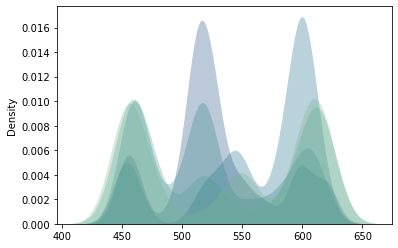

In [27]:
sns.kdeplot(
   data=[wavelengths_asia, wavelengths_europe, wavelengths_americas, wavelengths_africa, wavelengths_oceania],#, x="total_bill", hue="size",
   fill=True, common_norm=False, palette="crest",
   alpha=0.3, linewidth=0.0, bw_method=0.2,
   legend=False
)

### Check Benford's law

<AxesSubplot:ylabel='Count'>

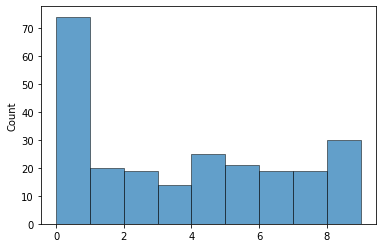

In [28]:
last_digits = [int(x[-1]) for x in populations]
sns.histplot(
   last_digits, bins=range(10),palette="crest",
   alpha=0.7, linewidth=0.5
)

In [29]:
def extract_info(entry, start, end, included=True):
    src = str(entry)
    pos_start = src.find(start) + 0 if included else len(start)
    pos_end = src.find(end) + len(end) if included else 0
    return src[pos_start:pos_end]

In [37]:
URL = 'https://en.wikipedia.org/wiki/Gallery_of_sovereign_state_flags'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

entries = soup.find_all('li', class_='gallerybox')
flag_links = ['https:' + extract_info(entry, '//upload.wikimedia.org/', '.svg.png') for entry in entries]
print(len(flag_links))
#extract_info(sources[0], '">"', '</a>', included=False)
np.sort(names)

207


array(['Abkhazia', 'Afghanistan', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'DR Congo',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'East Timor', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini